In [1]:
import os
import numpy as np
import torch
from torch import Tensor
from torch.nn.parameter import Parameter
from torch.autograd import Variable
import torch.nn.functional as F
from lib.dataset_custom import KernDataset,DatasetSplit
from lib.model import ScoreModel
from lib.opt import optimize
from lib.CrossValidation import CrossValidator
from lib.config import corpora_for_classification_all_composers as default_corpora
import lib.media as media

In [2]:
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='1'

checkpoint_dir = '_chords_cv'
context = 500
corpora = tuple(default_corpora)

In [3]:
class Convnet(ScoreModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def define_graph(self, debug=False):
        self.kernel_width = 1 # window with which we scan over time
        k = 200
        k2 = 80
        self.wnotes = Parameter(Tensor(k, 6*self.m, self.kernel_width))
        self.wdurations = Parameter(Tensor(k, 6*self.maxdur, self.kernel_width))
        #self.w2 = Parameter(Tensor(k2, k, self.kernel_width))
        self.w3 = Parameter(Tensor(k, self.composers))
        self.bias = Parameter(Tensor(self.composers))
    
    def forward(self, x):
        e,t,_,_ = x
        batch_size = e.shape[0]
        c1 = F.relu(F.conv1d(e.view(batch_size*3, context, 6*self.m).transpose(1, 2), self.wnotes) + 
                   F.conv1d(t.view(batch_size*3, context, 6*self.maxdur).transpose(1, 2), self.wdurations))
        fullPool = c1.view(batch_size,3,-1,context).mean(1).mean(2)
        return torch.mm(fullPool, self.w3) + self.bias[None, :].expand(e.shape[0], -1)

In [4]:
validator = CrossValidator(Convnet, corpora, is_patches_model=True, patience=50, batch_size=256)

---------------------------------------------
---------------------------------------------
Fold 0
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([200, 468, 1]) (93600)
wdurations torch.Size([200, 330, 1]) (66000)
w3 torch.Size([200, 20]) (4000)
bias torch.Size([20]) (20)
Initialized graph with 163620 parameters
Initiating optimizer, 8 iterations/epoch.
acc_tr	acc_ts	iter	loss_tr	loss_ts	time	utime
0.50    0.43    0       4.32    4.32    17.02   8.41    
26.50   27.59   8       4.18    4.15    15.77   8.48    
31.00   32.76   16      3.77    3.71    15.55   8.33    
34.50   36.64   24      3.29    3.23    14.17   7.83    
38.50   39.66   32      2.88    2.84    17.78   7.25    
43.50   43.10   40      2.55    2.53    15.27   7.86    
48.00   46.12   48      2.29    2.29    16.97   6.83    
50.50   50.00   56      2.08 

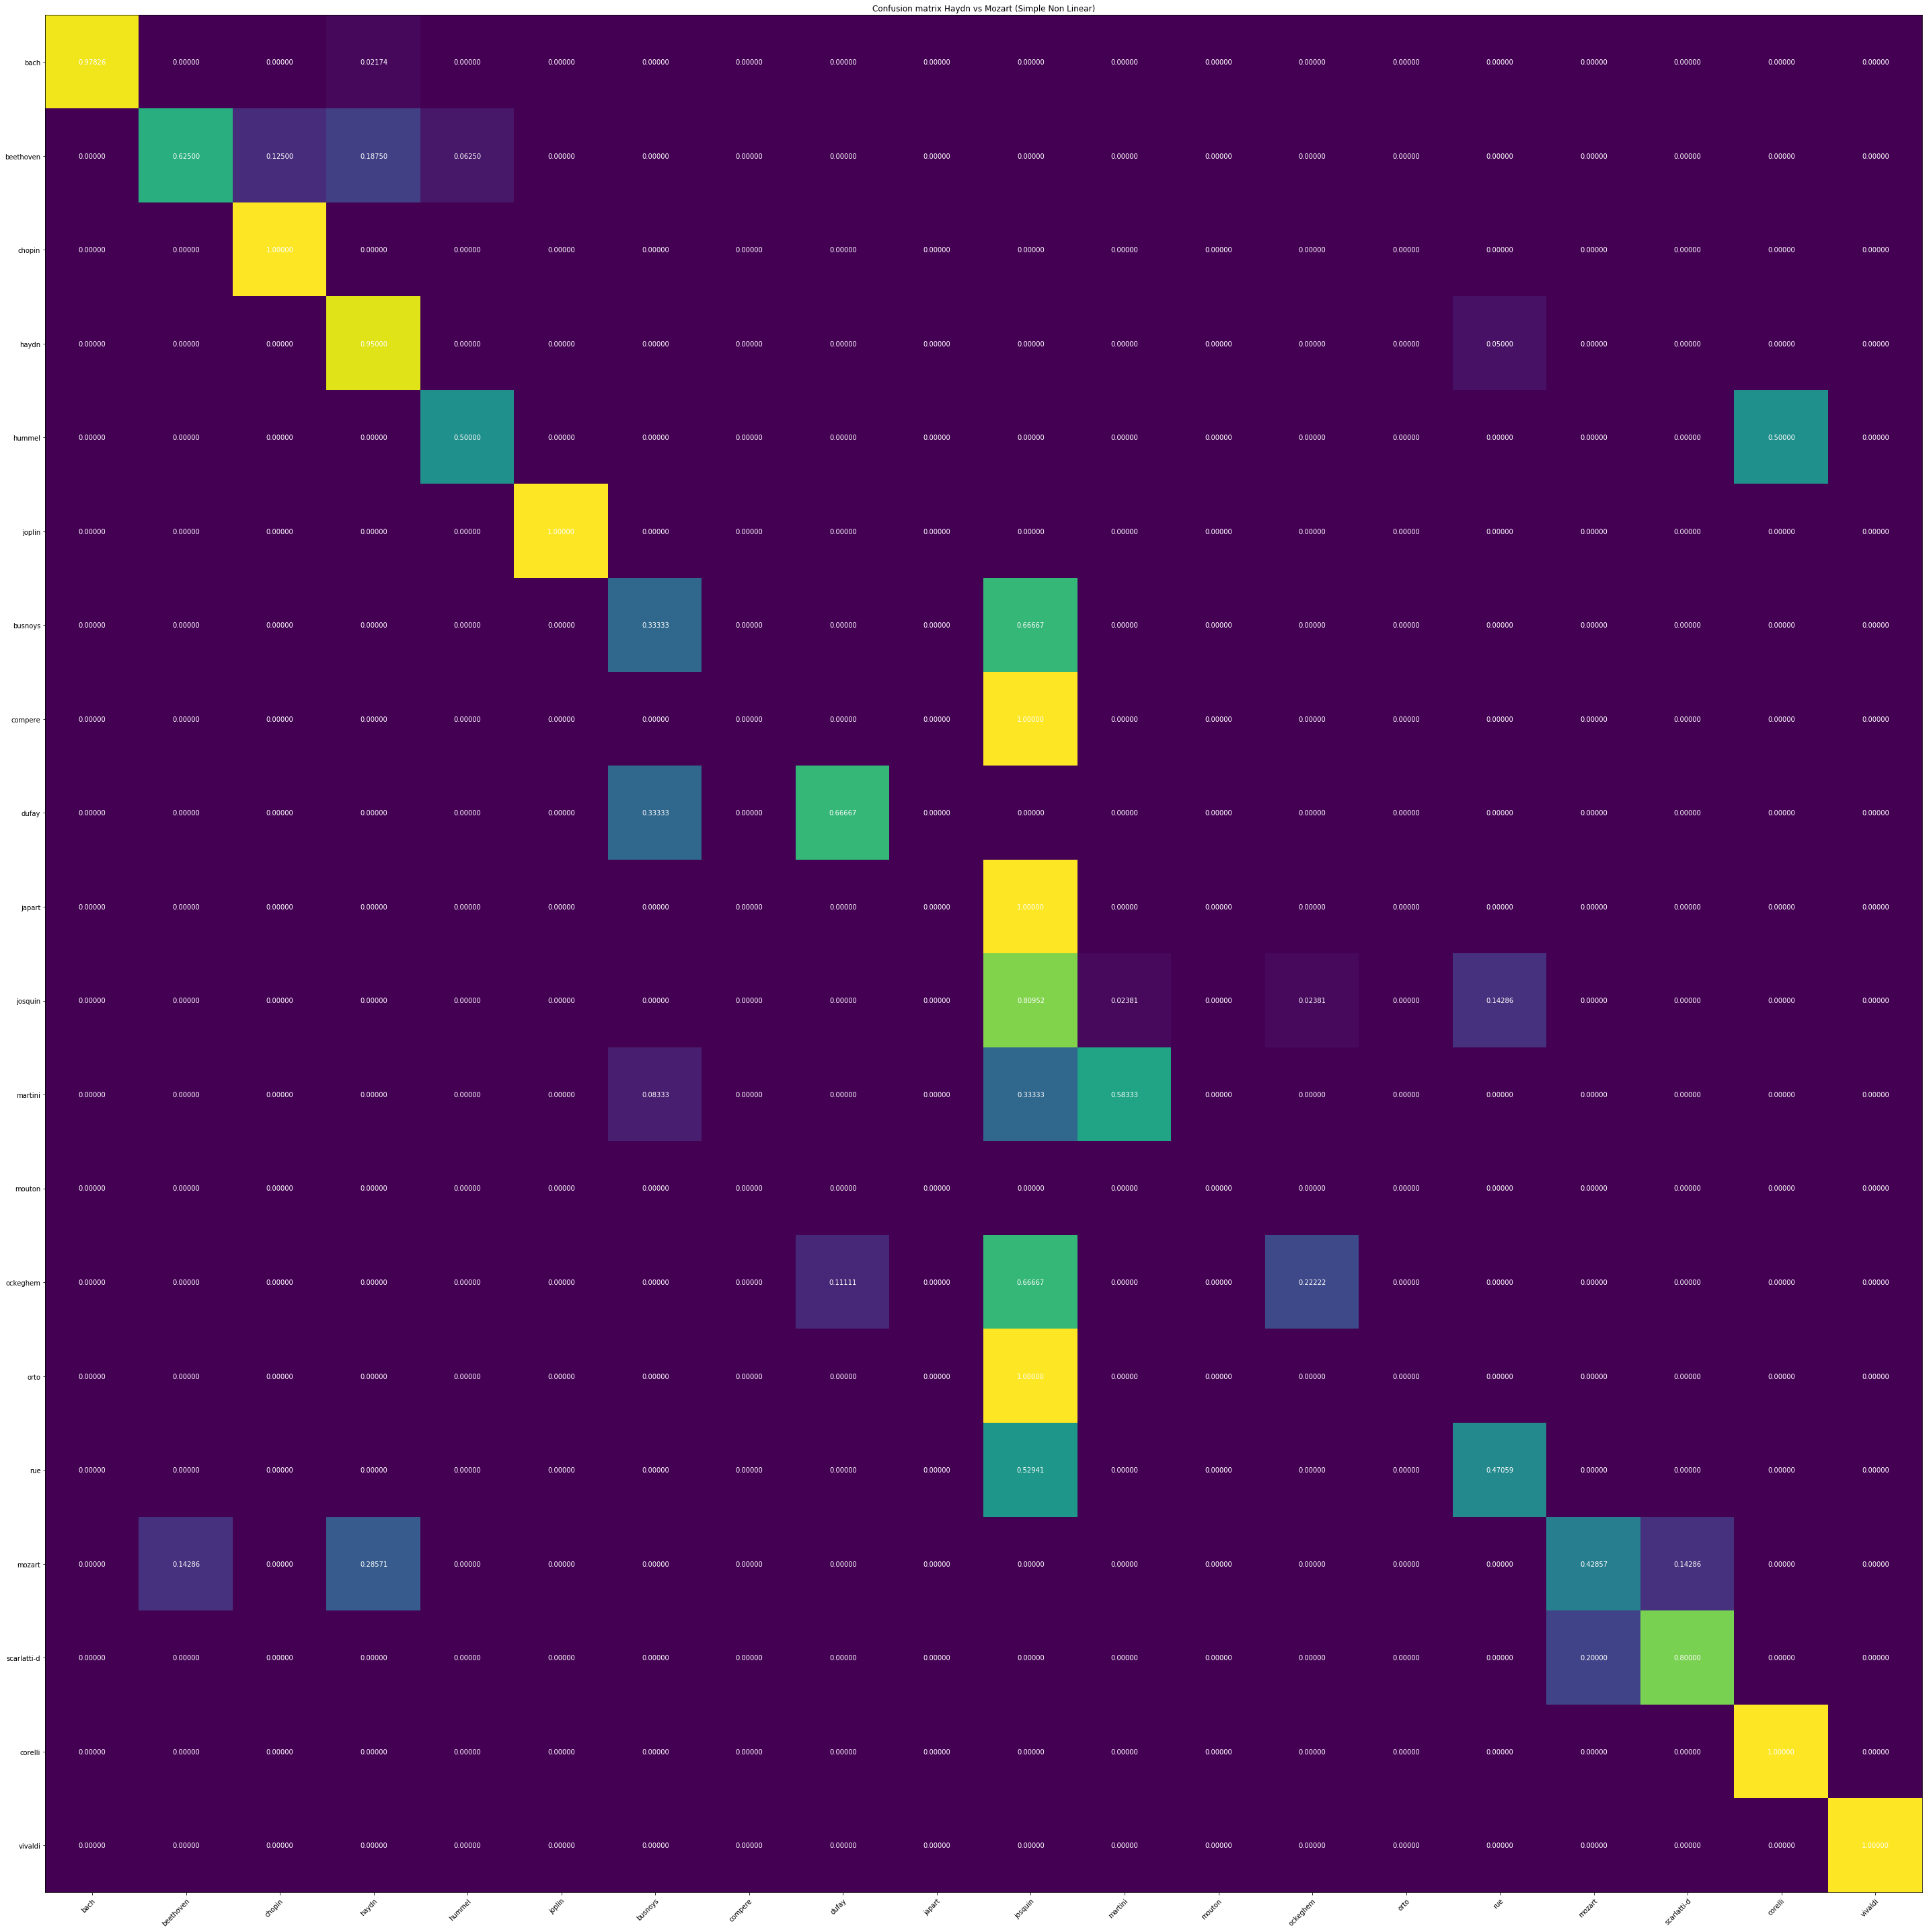

bach 45 / 46 = 0.9782608695652174
beethoven 10 / 16 = 0.625
busnoys 2 / 6 = 0.3333333333333333
chopin 7 / 7 = 1.0
compere 0 / 2 = 0.0
corelli 18 / 18 = 1.0
dufay 2 / 3 = 0.6666666666666666
haydn 19 / 20 = 0.95
hummel 1 / 2 = 0.5
japart 0 / 2 = 0.0
joplin 4 / 4 = 1.0
josquin 34 / 42 = 0.8095238095238095
martini 7 / 12 = 0.5833333333333334
mozart 6 / 14 = 0.42857142857142855
ockeghem 2 / 9 = 0.2222222222222222
orto 0 / 4 = 0.0
rue 8 / 17 = 0.47058823529411764
scarlatti-d 4 / 5 = 0.8
vivaldi 1 / 1 = 1.0
170 230 0.7391304347826086
---------------------------------------------
---------------------------------------------
Fold 1
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([200, 468, 1]) (93600)
wdurations torch.Size([200, 330, 1]) (66000)
w3 torch.Size([200, 20]) (4000)
bias torch.Size([20]) (20)
Initialized graph with 1

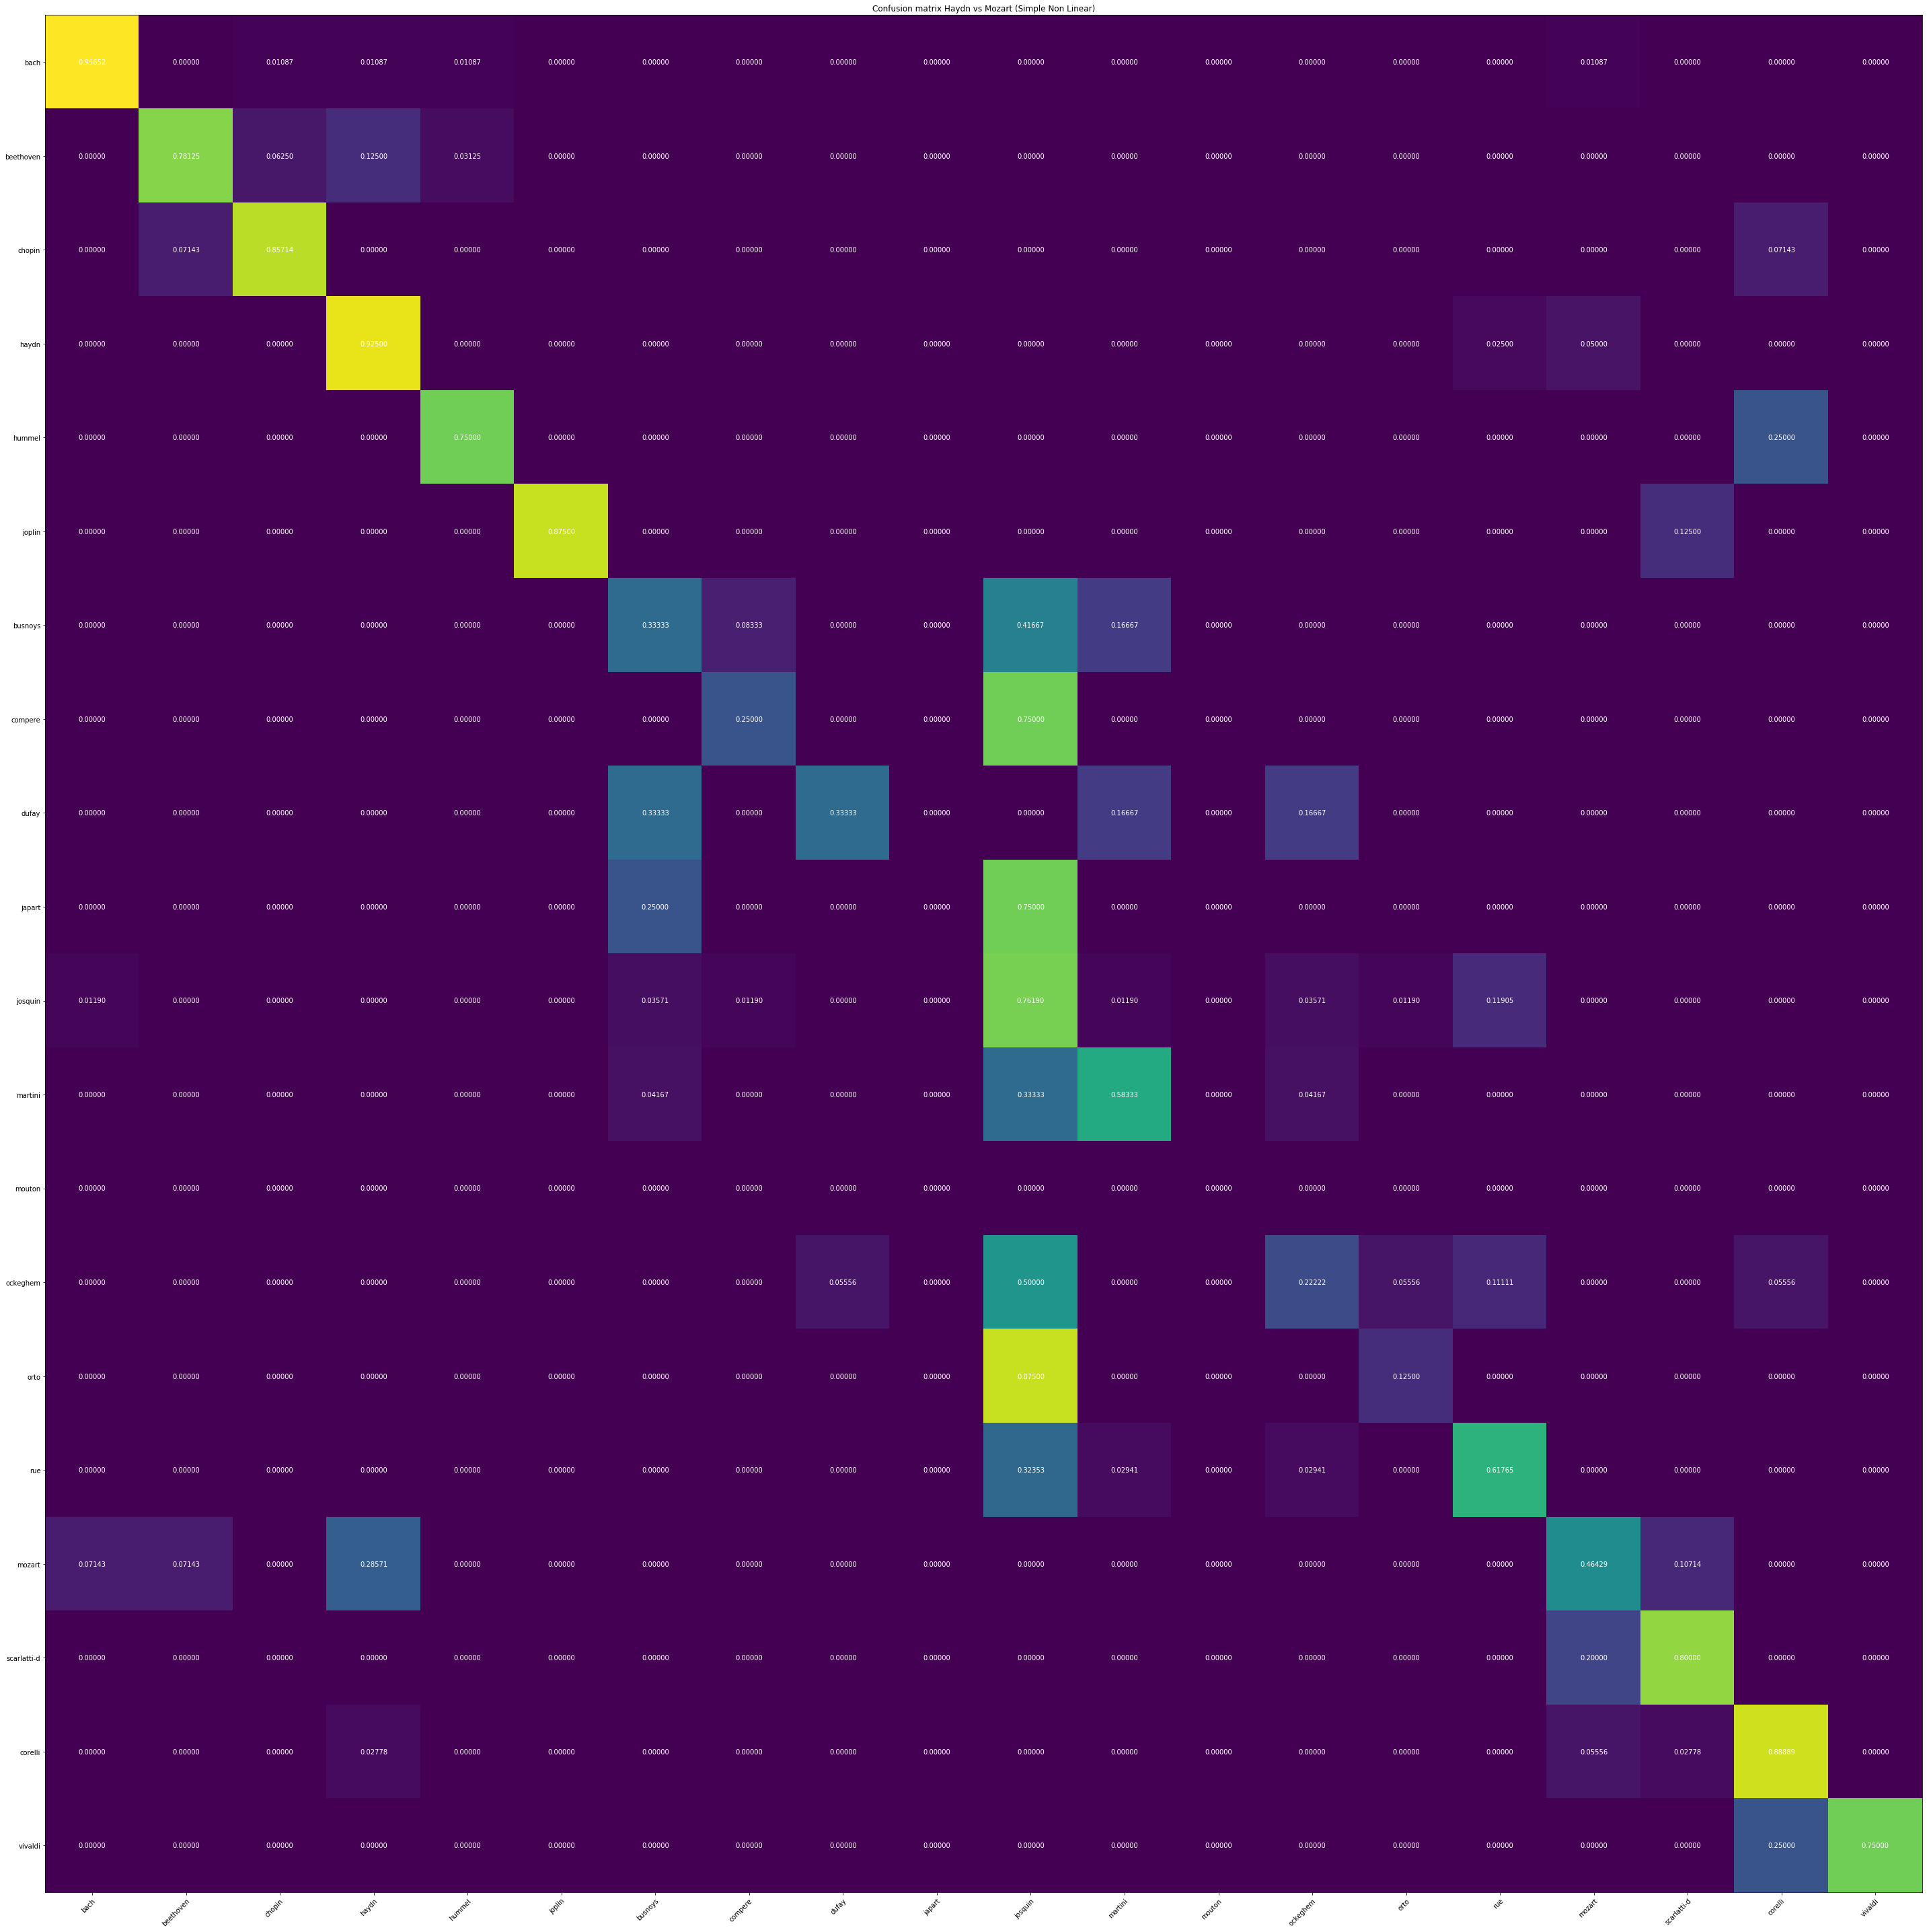

bach 43 / 46 = 0.9347826086956522
beethoven 15 / 16 = 0.9375
busnoys 2 / 6 = 0.3333333333333333
chopin 5 / 7 = 0.7142857142857143
compere 1 / 2 = 0.5
corelli 14 / 18 = 0.7777777777777778
dufay 0 / 3 = 0.0
haydn 18 / 20 = 0.9
hummel 2 / 2 = 1.0
japart 0 / 2 = 0.0
joplin 3 / 4 = 0.75
josquin 30 / 42 = 0.7142857142857143
martini 7 / 12 = 0.5833333333333334
mozart 7 / 14 = 0.5
ockeghem 2 / 9 = 0.2222222222222222
orto 1 / 4 = 0.25
rue 13 / 17 = 0.7647058823529411
scarlatti-d 4 / 5 = 0.8
vivaldi 2 / 3 = 0.6666666666666666
169 232 0.728448275862069
---------------------------------------------
---------------------------------------------
Fold 2
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([200, 468, 1]) (93600)
wdurations torch.Size([200, 330, 1]) (66000)
w3 torch.Size([200, 20]) (4000)
bias torch.Size([20]) (20)
Initializ

In [ ]:
validator.run(context, checkpoint_dir=checkpoint_dir)